# Socioeconomic data and TOC entitlements
* Entitlements assigned to census tracts
* Which census tracts (what income levels or median household income) have seen TOC entitlements?
* See if tract is composed of mostly TOC-eligible parcels
* Then look at Census characteristics of mostly TOC-eligible tracts vs not

In [1]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import laplan

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## A. Merge in number of TOC entitlements that tract had

In [3]:
crosswalk_parcels_tracts = catalog.crosswalk_parcels_tracts.read()

keep = ["GEOID", "toc_AIN", "toc_area"]
crosswalk_parcels_tracts = (crosswalk_parcels_tracts[keep]
                            .drop_duplicates()
                            .sort_values("GEOID")
                            .reset_index(drop=True)
                           )

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [4]:
# Download parcels with TOC entitlement info, and only keep parcels with TOC ent
def tracts_with_TOC_ent():    
    parcels = catalog.toc_parcels_with_entitlements.read().to_crs('EPSG:4326')
    toc_parcels = parcels[parcels.num_TOC > 0][['AIN', 'num_TOC', 'num_nonTOC']]

    crosswalk_parcels_tracts = catalog.crosswalk_parcels_tracts.read()
    crosswalk_parcels_tracts = crosswalk_parcels_tracts[["AIN", "GEOID"]]
    
    df = pd.merge(crosswalk_parcels_tracts[["AIN", "GEOID"]], 
         toc_parcels, on = "AIN", how = "left", validate = "1:1")
    
    # Fill in NaNs with zeroes
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    # Aggregate to tract-level
    df = (df.groupby("GEOID")
          .agg({"num_TOC": "sum", "num_nonTOC": "sum"})
          .reset_index()
         )
    
    return df

In [5]:
toc_ent = tracts_with_TOC_ent()

In [6]:
# Merge together with whether tract is TOC eligibility or not
df = pd.merge(crosswalk_parcels_tracts, toc_ent, on = "GEOID", how = "left", validate = "1:1")
df.head()

,GEOID,toc_AIN,toc_area,num_TOC,num_nonTOC
0,06037101110,0,0,0,0
1,06037101122,0,0,0,0
2,06037101210,0,0,0,0
3,06037101220,0,0,0,0
4,06037101300,0,0,0,0


## B. Merge in Census data

In [7]:
tracts = catalog.census_tracts.read().to_crs("EPSG:4326")
tracts = (tracts[["GEOID10", "geometry"]]
          .rename(columns = {"GEOID10": "GEOID"})
         )

census_stats = catalog.census_analysis_table.read()

census = pd.merge(tracts, census_stats, on = "GEOID", how = "left", validate = "1:1")

In [8]:
final = pd.merge(census, df, on  = "GEOID", how = "left", validate = "1:1")

## C1. Summary stats
Instead of unweighted averages, we should definitely weight by population. 
Aggregate counts for # non car, # zero veh workers, etc into the group first.
Then calculate % non car, % zero veh workers, medincome etc.

In [9]:
# Already have info whether tract is 50% or more (by area or # AIN) TOC-eligible
# Now add info about how many actual TOC entitlements occurred
def set_groups(df):
   
    def set_cutoffs(row):

        toc_ENT = 0
        toc_ENT_group = 0
        
        if row.num_TOC > 0:
            toc_ENT = 1
            
            if row.num_TOC <= 5:
                toc_ENT_group = 1
            if (row.num_TOC > 5) and (row.num_TOC <= 10):
                toc_ENT_group = 2
            if row.num_TOC > 10:
                toc_ENT_group = 3
        
        return pd.Series([toc_ENT, toc_ENT_group], 
                         index=['toc_ENT', 'toc_ENT_group'])
    
    with_cutoffs = df.apply(set_cutoffs, axis=1)
    
    df = pd.concat([df, with_cutoffs], axis=1)
    
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    return df

In [10]:
final = set_groups(final)
final.head(2)

,GEOID,geometry,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,...,total_r150to199,total_gt200,total_total,density,toc_AIN,toc_area,num_TOC,num_nonTOC,toc_ENT,toc_ENT_group
0,06037297602,"MULTIPOLYGON (((-118.28798 33.72258, -118.2879...",101,1840,0.054891,77,0.041848,2065,3730,0.553619,...,163,158,1685,15527.244301,0.0,0.0,0,0,0,0
1,06037297601,"MULTIPOLYGON (((-118.27738 33.70783, -118.2773...",42,1147,0.036617,26,0.022668,2244,2706,0.829268,...,60,77,1219,9446.228426,0.0,0.0,0,0,0,0


In [11]:
# Calculate IQR for income
def aggregate_by_toc(df, category_col, income_df):
    df = df[["GEOID", category_col]]

    df2 = pd.merge(df, income_df, on = "GEOID", how = "left", validate = "1:1")

    # Aggregate by toc_area or toc_AIN
    df2 = df2.pivot_table(index = category_col, aggfunc = "sum").reset_index()
    
    # Calculate IQR
    iqr = (df2.apply(
            lambda r: pd.Series(laplan.census.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", 
                            "Q2": "income_Q2", 
                            "Q3": "income_Q3"})
    )

    # Merge IQR in
    df3 = pd.merge(df2[[category_col]], iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
    return df3

def summary_stats(df, category_col, income_df):
    # Number of tracts by cut-offs
    num_tracts = (df.groupby(category_col).agg({
            "GEOID": "count"
        }).reset_index()
            .rename(columns = {"GEOID": "num_tracts"})
    )
    
    # Calculate totals
    totals = df.groupby(category_col).agg({
            "zero_veh_workers": "sum",
            "non_car_workers": "sum",
            "workers_total": "sum",
            "pop_renter": "sum",
            "pop_whitenonhisp": "sum",
            "pop_total": "sum",
    }).reset_index()
    
    # Calculate percents
    percents = totals.assign(
        pct_zero_veh = totals.zero_veh_workers / totals.workers_total,
        pct_non_car = totals.non_car_workers / totals.workers_total,
        pct_renter = totals.pop_renter / totals.pop_total,
        pct_white = totals.pop_whitenonhisp / totals.pop_total,
    )
    
    # Calculate income IQR
    income_iqr = aggregate_by_toc(df, category_col, income_df)
    
    # Create final table
    summary = pd.merge(percents, num_tracts, on = category_col, validate = "1:1")
    summary = pd.merge(summary, income_iqr, on = category_col, validate = "1:1")
    
    return summary

In [12]:
# Create a subset df that pulls out incomerange columns from census stats
income_ranges = laplan.census.CENSUS_INCOME_RANGES

# The new_var columns to keep all have prefix "total_". 
# Can switch out if we're interested in other races' income ranges
keep = []
for x in income_ranges:
    keep.append("total_" + x)

keep.append("GEOID")

income = census_stats[keep]

income.head(2)

,total_lt10,total_r10to14,total_r15to19,total_r20to24,total_r25to29,total_r30to34,total_r35to39,total_r40to44,total_r45to49,total_r50to59,total_r60to74,total_r75to99,total_r100to124,total_r125to149,total_r150to199,total_gt200,total_total,GEOID
0,110,97,70,76,123,96,54,78,88,64,126,277,91,93,109,44,1596,06037101110
1,52,18,0,15,39,38,7,40,23,62,186,232,114,105,133,192,1256,06037101122


In [13]:
# TOC tracts: 50% of AIN in TOC Tier or not
by_AIN = summary_stats(final, "toc_AIN", income)
by_AIN

,toc_AIN,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0.0,25474,68832,908927,835758,703288,1840124,0.028026,0.075729,0.454186,0.382196,458,35706.354135,74136.576818,136991.458463
1,1.0,95431,198640,1046500,1501681,443151,2082857,0.091191,0.189814,0.720972,0.212761,549,22581.190387,48225.917068,93110.836769


In [14]:
# TOC tracts: 50% of area in TOC Tier or not
by_area = summary_stats(final, "toc_area", income)
by_area

,toc_area,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0.0,25446,70538,917375,836060,720199,1853999,0.027738,0.076891,0.450950,0.388457,462,36023.087637,74734.185386,138170.991874
1,1.0,95459,196934,1038052,1501379,426240,2068982,0.091960,0.189715,0.725661,0.206014,545,22358.011215,47672.337644,92041.996104


In [15]:
# TOC tracts: has TOC ENT or not
by_toc_ENT = summary_stats(final, "toc_ENT", income)
by_toc_ENT

,toc_ENT,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,1200400,3897980,0.048038,0.115035,0.549060,0.307954,978,29159.684490,63494.382301,120280.513445
1,1,38108,73175,344591,499233,170136,633886,0.110589,0.212353,0.787575,0.268402,171,23698.807672,49645.214521,94661.588643


In [16]:
# TOC tracts: by number of TOC ENT
by_num_TOC_ENT = summary_stats(final, "num_TOC", income)
by_num_TOC_ENT

,num_TOC,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,1200400,3897980,0.048038,0.115035,0.549060,0.307954,978,29159.684490,63494.382301,120280.513445
1,1,17669,33036,147191,218484,74946,276150,0.120041,0.224443,0.791179,0.271396,77,23105.245334,49096.885371,96277.966176
2,2,8244,16186,71534,102169,30438,130659,0.115246,0.226270,0.781951,0.232958,35,24176.171393,49264.705882,93052.997321
3,3,4104,7683,38273,54338,18598,70195,0.107230,0.200742,0.774101,0.264948,17,23703.733766,47264.279238,88867.320819
4,4,2062,3795,19192,25208,12368,33039,0.107441,0.197739,0.762977,0.374345,10,23499.377335,51527.138914,96289.993193
5,5,608,1936,13328,18994,7939,24627,0.045618,0.145258,0.771267,0.322370,7,24347.744361,50139.705882,99031.520693
6,6,2021,3816,20093,30467,6098,36365,0.100582,0.189917,0.837811,0.167689,9,24117.054611,47617.041199,85287.735849
7,7,814,1772,9444,13522,5944,16779,0.086192,0.187632,0.805888,0.354252,5,30067.237164,55511.551155,100748.337029
8,8,1119,2014,9548,14536,4818,16891,0.117197,0.210934,0.860577,0.285241,4,20300.000000,50563.380282,87991.128010
9,10,1309,2379,10892,16332,3929,19658,0.120180,0.218417,0.830807,0.199868,5,23419.715447,47395.543175,90136.430678


In [17]:
# TOC tracts: by grouping the number of TOC ENT into 3 groups
# 0: num_TOC = 0
# 1: 1-5
# 2: 6-10
# 3: 11+
by_TOC_ENT_group = summary_stats(final, "toc_ENT_group", income)
by_TOC_ENT_group

,toc_ENT_group,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,1200400,3897980,0.048038,0.115035,0.549060,0.307954,978,29159.684490,63494.382301,120280.513445
1,1,32687,62636,289518,419193,144289,534670,0.112901,0.216346,0.784022,0.269866,146,23534.720068,49113.666707,94604.456794
2,2,5263,9981,49977,74857,20789,89693,0.105308,0.199712,0.834591,0.231780,23,23921.284364,49726.428080,90109.563148
3,3,158,558,5096,5183,5058,9523,0.031005,0.109498,0.544261,0.531135,2,41752.717391,84069.767442,144648.437500


In [18]:
# Produce summary stats for tracts that switch categories
def summary_stats_switches(df, income_df):

    # Calculate percents
    percents = df.assign(
        pct_zero_veh = df.zero_veh_workers / df.workers_total,
        pct_non_car = df.non_car_workers / df.workers_total,
        pct_renter = df.pop_renter / df.pop_total,
        pct_white = df.pop_whitenonhisp / df.pop_total,
    )
    
     # Calculate IQR
    iqr = (income_df.apply(
            lambda r: pd.Series(laplan.census.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", 
                            "Q2": "income_Q2", 
                            "Q3": "income_Q3"})
    )

    # Merge IQR in
    income_iqr = pd.merge(income_df, iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
        
    # Create final table
    summary = pd.merge(percents, income_iqr, on = "GEOID", validate = "1:1")
    
    keep = ["GEOID", "pct_zero_veh", "pct_non_car", "pct_renter", "pct_white", 
           "income_Q1", "income_Q2", "income_Q3", "toc_AIN", "toc_area"]
    
    summary = summary[summary.toc_AIN != summary.toc_area][keep].reset_index(drop=True)
    
    return summary

switches = summary_stats_switches(final, income)
switches.head()

,GEOID,pct_zero_veh,pct_non_car,pct_renter,pct_white,income_Q1,income_Q2,income_Q3,toc_AIN,toc_area
0,06037670602,0.007923,0.024113,0.192486,0.619219,64553.571429,150399.543379,225312.500000,NaN,NaN
1,06037670001,0.014723,0.033975,0.307760,0.409171,36686.320755,70297.619048,118043.154762,NaN,NaN
2,06037543703,0.014067,0.031804,0.180472,0.086155,47730.263158,94427.710843,143113.425926,NaN,NaN
3,06037609900,0.013285,0.021739,0.545503,0.293241,29861.111111,65869.565217,104861.111111,NaN,NaN
4,06037543604,0.003008,0.049248,0.148155,0.087914,63716.517857,96434.563758,139190.051020,NaN,NaN


In [19]:
if not os.path.exists("../outputs"):
    os.mkdir("../outputs")
writer = pd.ExcelWriter("../outputs/07-toc-census-stats.xlsx", engine="xlsxwriter")

by_AIN.to_excel(writer, sheet_name = "by_pct_AIN")
by_area.to_excel(writer, sheet_name = "by_pct_area")
by_toc_ENT.to_excel(writer, sheet_name = "by_TOC_ENT")
by_num_TOC_ENT.to_excel(writer, sheet_name = "by_num_TOC_ENT")
by_TOC_ENT_group.to_excel(writer, sheet_name = "by_TOC_ENT_group")
switches.to_excel(writer, sheet_name = "switches")

writer.save()

## C2. Make map of tracts

<AxesSubplot:title={'center':'TOC Tracts by % AIN'}>

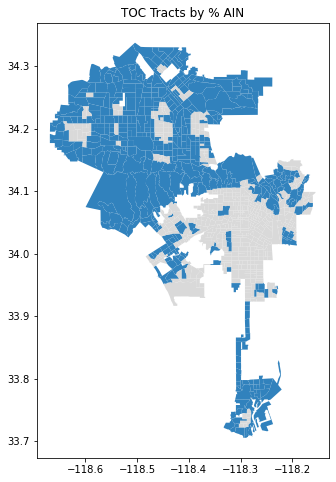

In [20]:
# By AIN
final = final.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by % AIN")
final.plot(column="toc_AIN", ax=ax, cmap = "tab20c", legend=False)

<AxesSubplot:title={'center':'TOC Tracts by having TOC Entitlements'}>

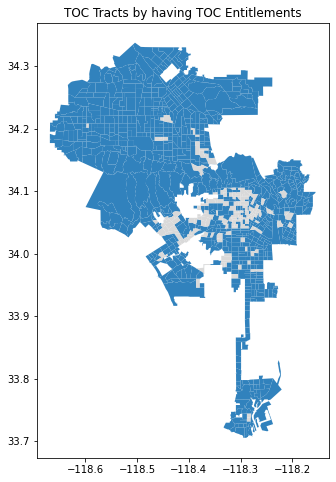

In [21]:
# By TOC ENT
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by having TOC Entitlements")
final.plot(column="toc_ENT", ax=ax, cmap = "tab20c", legend=False)

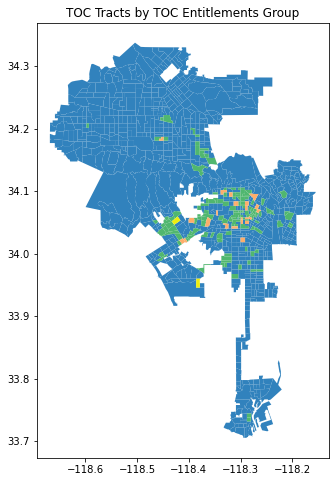

In [22]:
# By TOC ENT group
colors = {0: '#3182bd', # blue
          1: '#50b76f', # green
          2: '#fdae6b', # orange
          3: '#eded0f'} # yellow

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by TOC Entitlements Group")

for ctype, data in final.groupby('toc_ENT_group'):
    
    # Define the color for each group using the dictionary
    color = colors[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype, 
              legend=True)

## C3. Tracts that switch

In [23]:
print(f"# tracts where groups differ based on cut-offs: {len(final[final.toc_area != final.toc_AIN])}")
print(final.toc_area.value_counts())
print(final.toc_AIN.value_counts())

final['different'] = final.apply(lambda row: 1 if row.toc_area != row.toc_AIN else 0, axis=1)
different = final[final.toc_area != final.toc_AIN]

# tracts where groups differ based on cut-offs: 172
1.0    545
0.0    462
Name: toc_area, dtype: int64
1.0    549
0.0    458
Name: toc_AIN, dtype: int64


<AxesSubplot:title={'center':'TOC Tracts that Switch Categories'}>

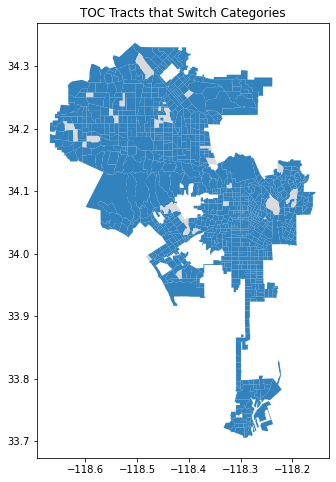

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts that Switch Categories")
final.plot(column = "different", ax=ax, cmap = "tab20c", legend=False)